In [1]:
import numpy as np, pylab as plt, pandas as pd
import pickle, os

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'

In [3]:
import networkx as nx, ase.io
class ValenceMap:
    
    def __init__(self, cifFile, mapFile, threshold=1.):
        self.threshold = threshold
        self.atoms = ase.io.read(cifFile)
        self.energy = self.get_map(mapFile)
        self.paths = {}
        
    def get_map(self,mapFile):
        with open(mapFile,'r') as f:
            ct = f.readlines()
            shape = tuple(int(i) for i in ct[2].split()) 
            U = np.array(ct[3].split()).reshape(shape).astype(float)
        return U
    
    def scaledPos2index(self,scaledPosition):
        scaledPosition = np.array(scaledPosition)
        return tuple((scaledPosition * np.array(self.energy.shape) - 0.5).astype(int))
        
    def get_pathEnergy(self,start,end):
        path = self.get_shortestPath(start,end)
        path = [tuple(i) for i in path]
        pathEnergy = [self.energy[point] for point in path]
        return pathEnergy

    def get_shortestPath(self,start, end):
        swapStartpoint = False
        start = self.scaledPos2index(start)
        end = self.scaledPos2index(end)
        if start not in self.paths and end not in self.paths:
            self.get_allPathsFrom(start)
            P = self.paths[start]
        elif start not in self.paths and end in self.paths:
            old_start = start
            start = end
            end = old_start
            swapStartpoint=True
        P = self.paths[start]
        Path = []
        step = end
        while 1:
            Path.append(step)
            if step == start: break
            step = P[step]
        if not swapStartpoint:
            Path.reverse()
        return np.asarray(Path)
            
    def get_allPathsFrom(self,startCell):
        U = self.energy
        U = np.ma.masked_array(U,U>self.threshold)
        mask = U.mask
        visit_mask = mask.copy() # mask visited cells
        m = np.ones_like(U) * np.inf
        connectivity = [(i,j,k) for i in [-1, 0, 1] \
                            for j in [-1, 0, 1] \
                            for k in [-1, 0, 1] \
                                if (not (i == j == k == 0))]
        cc = startCell

        m[cc] = 0
        P = {}  # dictionary of predecessors 
        #while (~visit_mask).sum() > 0:
        for _ in range(U.size):
            #print cc
            neighbors = [tuple(e) for e in np.asarray(cc) - connectivity 
                             if (e > 0).all() and (e < np.asarray(U.shape)).all() ]
            neighbors = [ e for e in neighbors if not visit_mask[e] ]
            tentative_distance = np.asarray([U[e]-U[cc] for e in neighbors])
            for i,e in enumerate(neighbors):
                d = tentative_distance[i] + m[cc]
                if d < m[e]:
                    m[e] = d
                    P[e] = cc
            visit_mask[cc] = True
            m_mask = np.ma.masked_array(m, visit_mask)
            cc = np.unravel_index(m_mask.argmin(), m.shape)
        self.paths[startCell] = P
    
    
    
    

In [4]:
pathEndpoints = {
    'lts':{'start':(0.41800,  0.32210,  0.75000),'end':(0.33333,  0.66667,  0.79100)},
    'lhs':{'start':(0.41300,  0.31100,  0.75000),'end':(0.33333,  0.66667,  0.79100)},
    'lys':{'start':(0.40500,  0.30300,  0.75000),'end':(0.33333,  0.66667,  0.79100)},
    'les':{'start':(0.41400,  0.31400,  0.75000),'end':(0.33333,  0.66667,  0.79100)},
    'nts':{'start':(0.66667,  0.33333,  0.75000),'end':(0.33333,  0.66667,  0.77190)},
    'nhs':{'start':(0.66667,  0.33333,  0.75000),'end':(0.33333,  0.66667,  0.77100)},
    'nys':{'start':(0.66667,  0.33333,  0.75000),'end':(0.33333,  0.66667,  0.77100)},
    'nes':{'start':(0.66667,  0.33333,  0.75000),'end':(0.33333,  0.66667,  0.77260)},
}

In [5]:
import os
os.path.isdir('shiftedValenceMapObjects')

True

In [6]:
import pickle

In [19]:
compounds = 'lts lhs lys les'.split()

ves = {}
paths = {}
pes = {}
c = 'lhs'
    
#V = ValenceMap(cifFile='{}_neutron.cif'.format(c.upper()),mapFile='./grds/{}_neutron_shift.grd'.format(c.upper()),threshold=1.2)

with open('./shiftedValenceMapObjects/{}_shift.pkl'.format(c),'rb') as f:
    V = pickle.load(f)

x = (0.68900,  0.10200,  0.75000)
y = (0.41300,  0.31100,  0.75000)

path = V.get_shortestPath(x,y)
paths[c] = path

pathEnergy = V.get_pathEnergy(x,y)
pes[c] = pathEnergy

y = (0.66667,  0.33333,  0.75000)
path2 = V.get_shortestPath(x,y)
pathEnergy2 = V.get_pathEnergy(x,y)

y = (0.33333,  0.66667,  0.79100)
path3 = V.get_shortestPath(x,y)
pathEnergy3 = V.get_pathEnergy(x,y)

with open('./shiftedValenceMapObjects/{}_shift.pkl'.format(c),'wb') as f:
    pickle.dump(V,f)
#pathEnergy = [V.energy[tuple(i)] for i in path]
#pes[c] = pathEnergy


In [20]:
from scipy.signal import savgol_filter

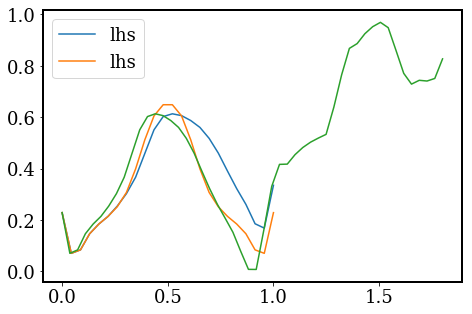

In [22]:
plt.rc('font', **{'family' : 'serif', 'size'   : 18})
fig,ax = plt.subplots(1,1,figsize=(7.5,5))
plt.setp(ax.spines.values(), linewidth=2)


pe = pes[c]
x = np.linspace(0,1,len(pe))

pe2 = pathEnergy2
pe2 = np.concatenate([pe2,pe2[::-1]])
x2 = np.linspace(0,1,len(pe2))

f = savgol_filter(pe,5,3)
f2 = savgol_filter(pe2,5,3)

ax.plot(x,f,label=c)
ax.plot(x2,f2,label=c)

x3 = np.linspace(0,1.8,len(pathEnergy3))
f3 = savgol_filter(pathEnergy3,5,3)
ax.plot(x3,f3)


ax.legend()    

In [42]:
for c in compounds:
    with open('./shiftedValenceMapObjects/{}_shift.pkl'.format(c),'rb') as f:
        ves[c] = pickle.load(f)

In [43]:
def index2pos(V,index):
    U = V.energy
    atoms = V.atoms
    ix = np.asarray(index)
    sx = (ix+0.5)/np.asarray(U.shape)
    ux = np.dot(atoms.cell.T,sx)
    return ux

from numpy.linalg import norm

pls = {}
for c in compounds:
    path = paths[c]
    V = ves[c]
    rp = np.array([index2pos(V,p) for p in path])
    dr = np.diff(rp,axis=0)
    pathLength = norm(dr,axis=1).cumsum()
    pls[c] = np.concatenate([[0],pathLength])

In [44]:
label = {'lts':'Tb','lhs':'Ho','lys':'Y','les':'Er'}

1.016086
0.971596
0.970551
0.990986


Text(0.42, 0.5, 'E$_{A4}$')

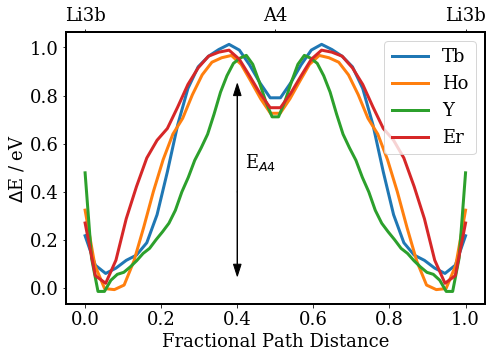

In [56]:
plt.rc('font', **{'family' : 'serif', 'size'   : 18})
fig,ax = plt.subplots(1,1,figsize=(7.5,5))
plt.setp(ax.spines.values(), linewidth=2)

for c in compounds:
    pe = pes[c]
    pe = pe[:-4]
    pe = np.concatenate([pe,pe[::-1]])
    x = np.linspace(0,1,len(pe))
    print(pe.max())
    #x = pls[c]
    #x = np.concatenate([x,x+x.max()])
    f = savgol_filter(pe,7,3)
    ax.plot(x,f,label=label[c],lw=3)
    
ax.legend(loc='upper right')    

ax.set_xlabel('Fractional Path Distance')
ax.set_ylabel('$\Delta$E / eV')

ax2=ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([0,0.5,1])
labs = ax2.set_xticklabels(['Li3b','A4','Li3b'])

ax.arrow(0.40,0.4,0,0.4,head_width=0.02,head_length = 0.05,fc='k',ec='k')
ax.arrow(0.40,0.4,0,-0.3,head_width=0.02,head_length = 0.05,fc='k',ec='k')
ax.text(0.42,0.5,'E$_{A4}$')

#plt.savefig('li_A4_activationEnergy.pdf',bbox_inches='tight')